# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**To-DO**

- Oil price
- inlflation [check]
- 


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def plot_experiment(model, ylims=None, names=[], title='Finance experiment'):
    """
    Plot currency exchange mogptk experiment
    """
    x_train = model.data.X
    y_train = model.data.Y
    x_all = model.data.X_all
    y_all = model.data.Y_all
    x_pred = {i:array for i, array in enumerate(data.X_all)}

    x_pred, mean_pred, var_pred = model.predict(x_pred)
    
    f, axarr = plt.subplots(5, 2, sharex=True, figsize=(20, 15))
    axarr = axarr.reshape(-1)
    
    for i in range(len(x_train)):
        axarr[i].plot(x_train[i][:, 0], y_train[i], '.k', label='Train', )
        axarr[i].plot(x_all[i][:, 0], y_all[i], '--', label='Test', c='gray')

        axarr[i].plot(x_pred[i][:, 0], mean_pred[i], label='Pred', c=sns.color_palette()[i])
        axarr[i].fill_between(x_pred[i][:, 0].reshape(-1),
                              mean_pred[i] + 2 * np.sqrt(var_pred[i]),
                              mean_pred[i] - 2 * np.sqrt(var_pred[i]),
                              label='95% c.i',
                              color=sns.color_palette()[i],
                              alpha=0.4)
        
        axarr[i].legend(ncol=4)
        axarr[i].set_title(names[i])
        axarr[i].set_xlim(-1, 730)
    plt.suptitle(title, y=1.02)
    plt.tight_layout()

## Load dataset

In [4]:
df = pd.read_csv('data/currency_exchange/final_dataset.csv')
df.head()

,Unnamed: 0,Day,CPI USA,CAD/USD,EUR/USD,JPY/USD,GBP/USD,CHF/USD,AUD/USD,HKD/USD,NZD/USD,KRW/USD,MXN/USD
0,2017-01-03,2,2.500042,1.3438,0.96013,117.67,0.81596,1.02659,1.3831,7.7563,1.4436,1208.5,20.909
1,2017-01-04,3,2.500042,1.3293,0.95461,117.43,0.81328,1.02277,1.3755,7.7553,1.4394,1198.6,21.385
2,2017-01-05,4,2.500042,1.3216,0.94353,115.42,0.80566,1.01078,1.3637,7.7545,1.4244,1183.2,21.399
3,2017-01-06,5,2.500042,1.3216,0.94704,116.85,0.81214,1.01513,1.3692,7.7552,1.4343,1200.4,21.302
4,2017-01-09,8,2.500042,1.3222,0.94558,116.08,0.82201,1.01489,1.3582,7.7559,1.4233,1202.0,21.336


## Create and fit model

In [5]:
# Add data
data = mogptk.Data()

# columns to use
cols = list(df)[3:]

for i, c in enumerate(cols):
    x = (df[['Day', 'CPI USA']].values).astype(float)
    # y = df2[c].values # normal
    y = np.log(df[c].values) # log
    
    # random remove
    idx = sorted(np.random.choice(len(x), size=int(0.6 * len(x)), replace=False))
    
    # filter by first input dim
    if i==0:
        idx2 = x[idx][:, 0] > 30
    elif i==1:
        idx2 = (x[idx][:, 0] < 90) | (x[idx][:, 0] > 120)
    elif i==2:
        idx2 = (x[idx][:, 0] < 480) | (x[idx][:, 0] > 520)
    elif i==3:
        idx2 = (x[idx][:, 0] < 200) | (x[idx][:, 0] > 250)
    elif i==4:
        idx2 = (x[idx][:, 0] > 30)
    elif i==7:
        idx2 = (x[idx][:, 0] < 500) | (x[idx][:, 0] > 550)
        
    if i>=3:
        idx2 = idx2 & (x[idx][:, 0] < 650)
    
    data.add(x[idx][idx2], y[idx][idx2])
    
# manuall all data overdrive
data.X_all = [df[['Day', 'CPI USA']].values for i in range(10)]
data.Y_all = [np.log(df[cols[i]].values) for i in range(10)]

Remove data to simulate sensor failure

In [11]:
# randomly sample from the data
# for i in range(len(cols)):
#    data.remove_randomly(channel=i, pct=0.6)

# drop chunks to simulate sensor failure
# data.remove_range(0, None, 30)
# data.remove_range(1, 90, 120)
# data.remove_range(2, 480, 520)
# data.remove_range(3, 200, 250)
# data.remove_range(4, None, 30)
# data.remove_range(7, 500, 550)



# for i in range(3, len(cols)):
#     data.remove_range(i, 650, None)

## MOSM

warning!!!, long time of execution

In [9]:
n_trials = 2

x_pred = {i:array for i, array in enumerate(data.X_all)}

mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=4)
    model_mosm.init_params('means')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=3000, disp=True, tol=1e-14)
    print('Finished trial', n)
    print('='*50)
    
    x, y_pred, var_pred = model_mosm.predict(x_pred)
    
    # errors per channel
    for i in range(len(cols)):
        idx = data.Y_all[i] != 0
        mosm_mae[n, i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
        mosm_mape[n, i] = np.abs((data.Y_all[i][idx] - y_pred[i][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
        mosm_mse[n, i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE

Starting trial 0
Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -9545.868294
  Number of iterations: 3000
  Number of functions evaluations: 3315
Done
Finished trial 0
Starting trial 1
Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -9550.113380
  Number of iterations: 3000
  Number of functions evaluations: 3215
Done
Finished trial 1


In [10]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_mse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_mse.std(0)],
                       columns=['MAE', 'MAPE%', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])

,MAE,MAPE%,MSE,MAE std,MAPE% std,MSE std
0,0.002050,0.763793,0.000027,0.000177,0.062313,0.000009
1,0.006504,8.736088,0.000724,0.000724,1.091008,0.000200
2,0.001962,0.041712,0.000020,0.000286,0.006078,0.000009
3,0.006127,2.441970,0.000228,0.000906,0.375309,0.000101
4,0.016729,546.640066,0.004869,0.013487,457.294590,0.004805
5,0.011742,3.664236,0.001556,0.003866,1.184019,0.001147
6,0.000953,0.046430,0.000007,0.000104,0.005074,0.000003
7,0.006564,1.736073,0.000241,0.000518,0.141704,0.000050
8,0.004995,0.071347,0.000125,0.000242,0.003452,0.000003
9,0.008123,0.271897,0.000364,0.000859,0.028543,0.000097


In [25]:
df_mosm = pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_mse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_mse.std(0)],
                       columns=['MAE', 'MAPE%', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])
df_mosm.to_csv('output/finance_mosm_error_with_cpi.csv')
df_mosm

,MAE,MAPE%,MSE,MAE std,MAPE% std,MSE std
0,0.003720,1.426702,0.000055,0.001721,0.657388,5.285043e-05
1,0.002678,2.480860,0.000024,0.000746,0.799298,2.090008e-05
2,0.003591,0.076166,0.000041,0.001076,0.022853,3.003201e-05
3,0.007160,2.776084,0.000157,0.001062,0.406916,3.019818e-05
4,0.003483,85.262012,0.000037,0.000297,11.369526,1.194347e-05
5,0.005977,1.971371,0.000167,0.000621,0.198582,4.465524e-05
6,0.001323,0.064339,0.000003,0.000185,0.009017,6.913994e-07
7,0.006382,1.731565,0.000165,0.001368,0.374390,7.358583e-05
8,0.003391,0.048293,0.000029,0.000289,0.004112,6.322140e-06
9,0.010351,0.347406,0.000462,0.004571,0.153778,3.970701e-04


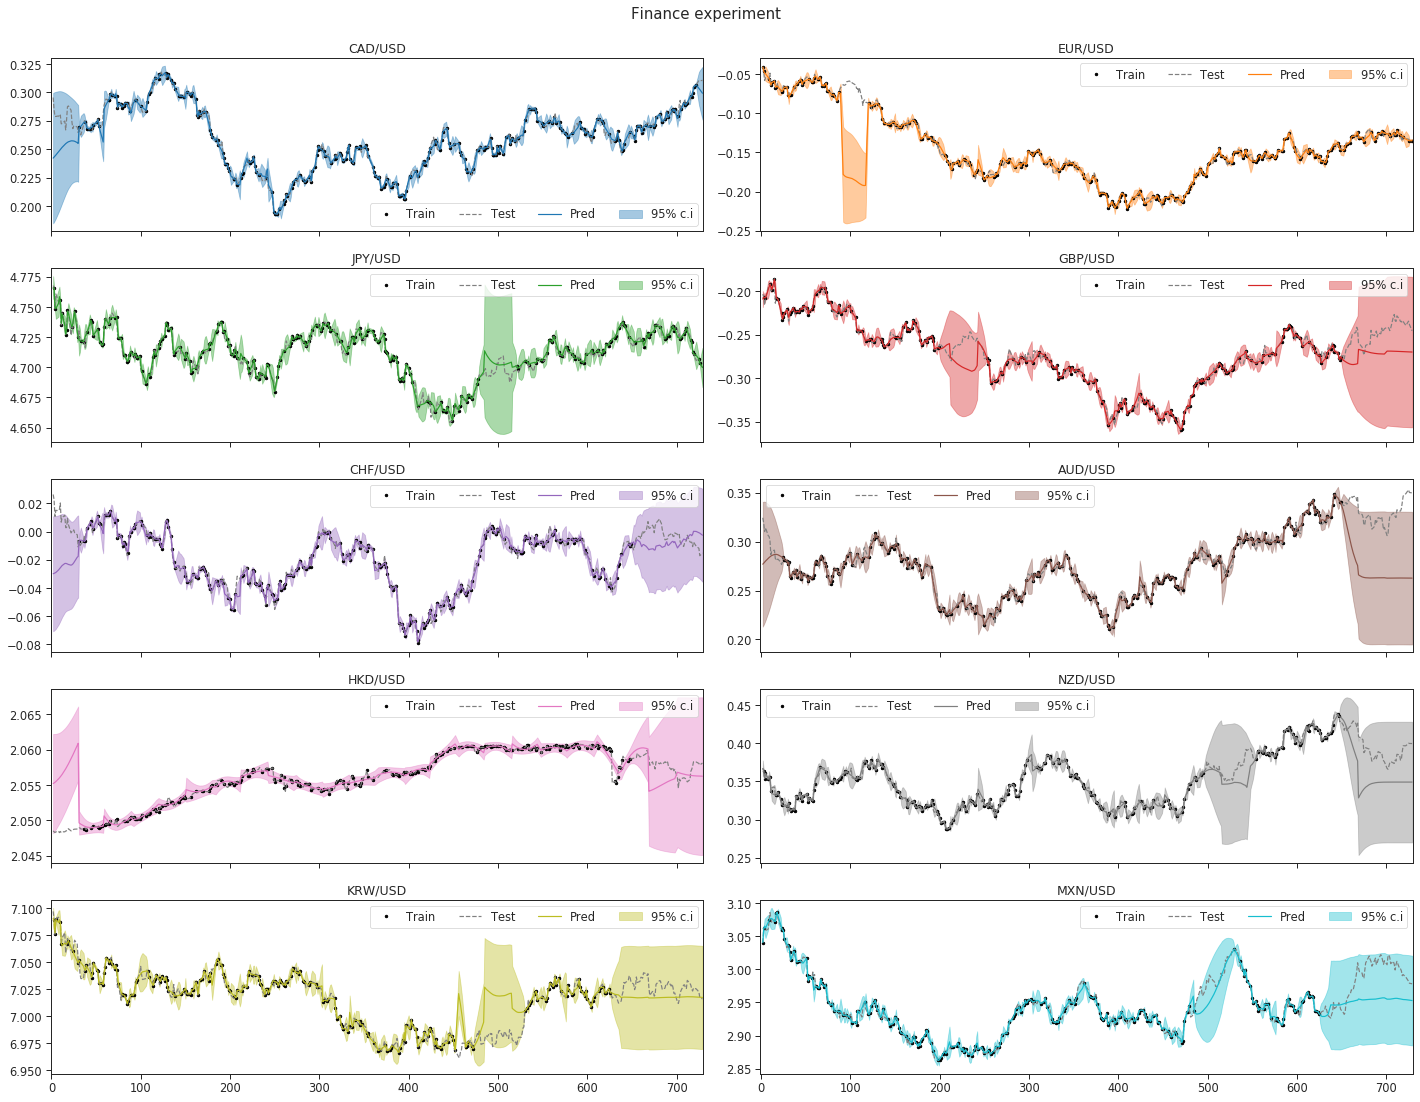

In [11]:
plot_experiment(model_mosm, names=cols)
# plt.savefig('output/finance_mosm_lognorm2.pdf', bbox_inches='tight')

## CSM

In [30]:
csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_mse = np.zeros((n_trials, len(cols)))

x_pred = {i:array for i, array in enumerate(data.X_all)}

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=4)
    model_csm.init_params()
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=3000, disp=False, tol=1e-14)
    print('Finished trial', n)
    print('='*50)
    
    x, y_pred, var_pred = model_csm.predict(x_pred)
    
    # errors per channel
    for i in range(len(cols)):
        idx = data.Y_all[i] != 0
        csm_mae[n, i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
        csm_mape[n, i] = np.abs((data.Y_all[i][idx] - y_pred[i][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
        csm_mse[n, i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -999.808251
  Number of iterations: 158
  Number of functions evaluations: 201
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -967.906633
  Number of iterations: 63
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -903.334406
  Number of iterations: 126
  Number of functions evaluations: 194
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -826.622251
  Number of iterations: 74
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -875.837725
  Number of iterations: 78
  Number of functions evaluations: 159
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -549.496665
  Number of iterations: 11
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -931.839295
  Number of iterations: 88
  Number of functions evaluations: 258
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -657.925648
  Number of iterations: 34
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -903.191472
  Number of iterations: 135
  Number of functions evaluations: 322
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -822.170892
  Number of iterations: 70
  Number of functions evaluations: 270
Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -4686.058291
  Number of iterations: 3000
  Number of functions evaluations: 3257
Finished trial 0
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -1038.816609
  Number of iterations: 68
  Number of functions evaluations: 261
INFO:tensorflow:Optimization terminated with:
  Message: Optimization termi

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 195.355368
  Number of iterations: 119
  Number of functions evaluations: 151
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -805.937119
  Number of iterations: 59
  Number of functions evaluations: 76
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -878.435000
  Number of iterations: 60
  Number of functions evaluations: 189
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -900.969887
  Number of iterations: 110
  Number of functions evaluations: 153


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 51.693828
  Number of iterations: 20
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -848.287570
  Number of iterations: 32
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -903.191472
  Number of iterations: 119
  Number of functions evaluations: 223
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -876.296785
  Number of iterations: 240
  Number of functions evaluations: 535
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5168.958039
  Number of iterations: 3000
  Number of functions evaluations: 3330
Finished trial 1
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -796.169313
  Number of iterations: 25
  Number of functions evaluations: 62
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Obj

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -1006.166180
  Number of iterations: 92
  Number of functions evaluations: 209
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -821.704697
  Number of iterations: 47
  Number of functions evaluations: 69
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -908.293720
  Number of iterations: 69
  Number of functions evaluations: 180
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -924.753836
  Number of iterations: 113
  Number of functions evaluations: 173


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 51.693828
  Number of iterations: 5
  Number of functions evaluations: 10
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -837.415505
  Number of iterations: 86
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -783.374295
  Number of iterations: 19
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -875.577029
  Number of iterations: 75
  Number of functions evaluations: 205
Starting trial 2


KeyboardInterrupt: 

In [ ]:
df_csm = pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_mse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_mse.std(0)],
                       columns=['MAE', 'MAPE%', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])
df_csm.to_csv('output/finance_csm_error.csv')
df_csm

## SM-LMC

In [ ]:
smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_mse = np.zeros((n_trials, len(cols)))

x_pred = {i:array for i, array in enumerate(data.X_all)}

for n in range(n_trials):
    model_smlmc = mogptk.SM_LMC(data, Q=4)
    model_smlmc.init_params()
    
    print('Starting trial', n)
    model_smlmc.train(method='L-BFGS-B', maxiter=3000, disp=True, tol=1e-14)
    print('Finished trial', n)
    
    x, y_pred, var_pred = model_smlmc.predict(x_pred)
    
    # errors per channel
    for i in range(len(cols)):
        idx = data.Y_all[i] != 0
        smlmc_mae[n, i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
        smlmc_mape[n, i] = np.abs((data.Y_all[i][idx] - y_pred[i][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
        smlmc_mse[n, i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE

## IGP
Independant gaussian process with spectral mixture kernel

In [ ]:
Q = 4

x_pred = {i:array for i, array in enumerate(data.X_all)}

igp_mae = np.zeros((n_trials, len(cols)))
igp_mape = np.zeros((n_trials, len(cols)))
igp_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):    

    for i in range(len(cols)):
        # create data
        data_single = mogptk.Data()
        data_single.add(data.X[i], data.Y[i])
        
        model = mogptk.SM(data_single, Q=Q)
        model.init_params('BNSE')
        model.train(method='L-BFGS-B', maxiter=3000, disp=True, tol=1e-15)
        
        idx = data.Y_all[i] != 0
        
        x, y_pred, var_pred = model.predict(x_pred)
        
        igp_mae[n, i] = np.abs(data.Y_all[i] - y_pred[0]).mean() # MAE
        igp_mape[n, i] = np.abs((data.Y_all[i][idx] - y_pred[0][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
        igp_mse[n, i] = ((data.Y_all[i] - y_pred[0])**2).mean() # MSE